# Bitcoin Transaction Analysis

## Import Functions from Utils and Necessary Libraries

In [1]:
from neo4j_utils import connect_to_neo4j, get_top_senders, get_frequent_pairs, get_mutual_transactions
from neo4j_utils import classify_wallet_tiers
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Connect to Neo4J Database and Start Analysis

### Finding Top Senders by count of Transactions

In [2]:
graph = connect_to_neo4j()

top_senders = get_top_senders(graph)
print(top_senders)

def plot_top_senders(df):
    plt.figure(figsize=(8, 4))
    plt.bar(df["sender"], df["tx_count"], color="skyblue")
    plt.title("Top Senders by Transaction Count")
    plt.xlabel("Sender Address")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

      sender  tx_count
0  wallet_16        19
1   wallet_8        17
2  wallet_10        17
3  wallet_19        16
4   wallet_3        16


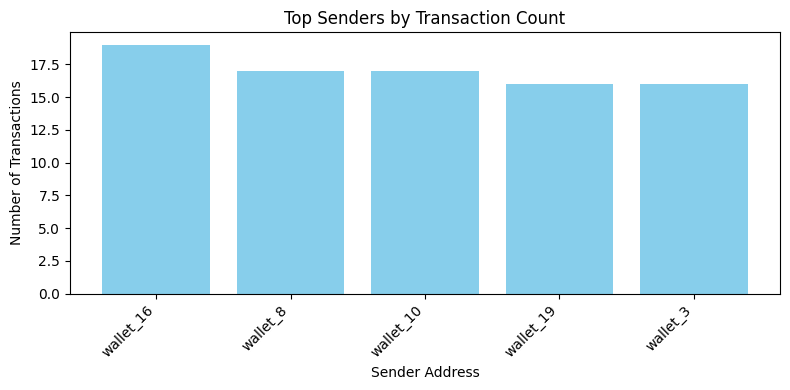

In [3]:
plot_top_senders(top_senders)

### Identifying frequently transacting wallets

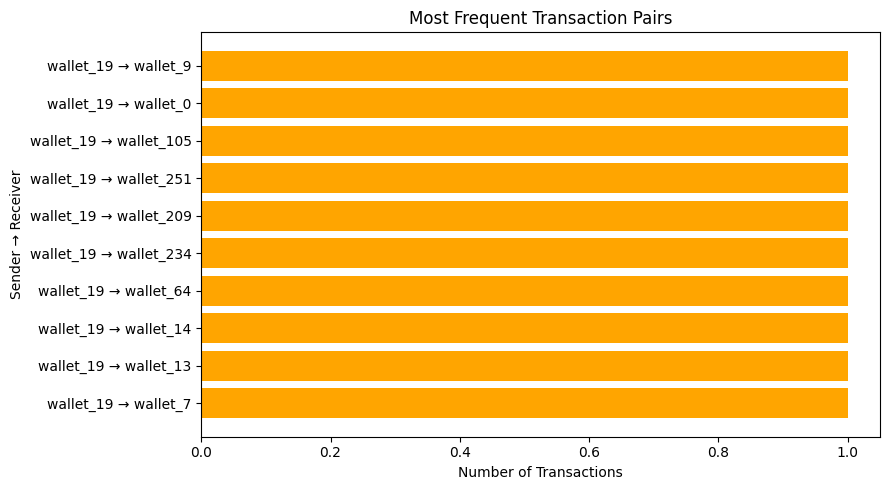

In [4]:
frequent_pairs = get_frequent_pairs(graph)

def plot_frequent_pairs(df):
    plt.figure(figsize=(9, 5))
    labels = [f"{s} → {r}" for s, r in zip(df["sender"], df["receiver"])]
    plt.barh(labels, df["tx_count"], color="orange")
    plt.title("Most Frequent Transaction Pairs")
    plt.xlabel("Number of Transactions")
    plt.ylabel("Sender → Receiver")
    plt.tight_layout()
    plt.show()

plot_frequent_pairs(frequent_pairs)

### Modeling the Mutual Transaction Network as a graph using NetworkX

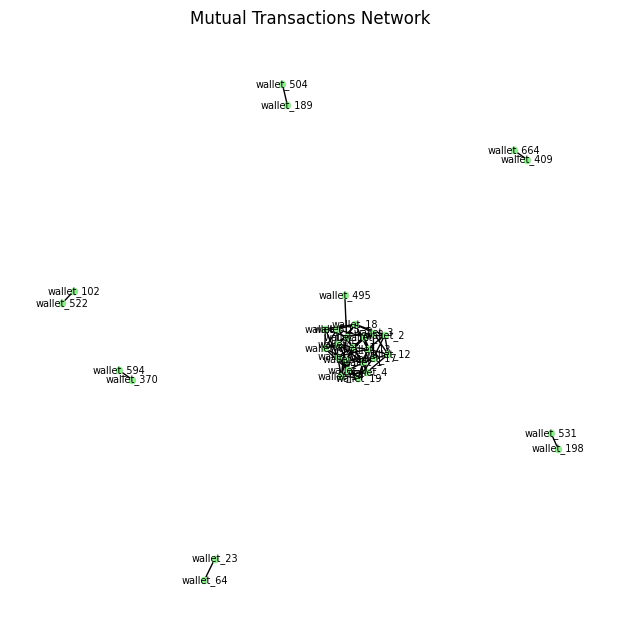

In [5]:
mutual_tx = get_mutual_transactions(graph)

def plot_mutual_transactions(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row["one"], row["two"])

    plt.figure(figsize=(6, 6))
    nx.draw(G, with_labels=True, node_color='lightgreen', node_size=20, font_size=7)
    plt.title("Mutual Transactions Network")
    plt.show()

plot_mutual_transactions(mutual_tx)

In [6]:
print(mutual_tx)

            one         two  tx_count
0     wallet_19    wallet_1         1
1     wallet_19   wallet_14         1
2     wallet_19   wallet_13         1
3     wallet_19    wallet_8         1
4     wallet_19    wallet_9         1
..          ...         ...       ...
139  wallet_370  wallet_594         1
140   wallet_23   wallet_64         1
141  wallet_409  wallet_664         1
142  wallet_102  wallet_522         1
143   wallet_64   wallet_23         1

[144 rows x 3 columns]


### Classifying the wallets based on transaction volumne

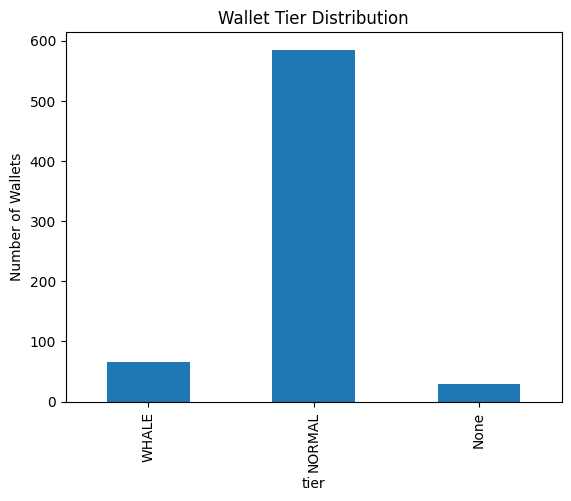

In [7]:
classify_wallet_tiers(graph)

df_tiers = graph.run("""
    MATCH (a:Address)
    RETURN a.tier AS tier, count(*) AS count
""").to_data_frame()

df_tiers.plot(kind="bar", x="tier", y="count", legend=False, title="Wallet Tier Distribution")
plt.ylabel("Number of Wallets")
plt.show()

### Time Series Plot

Index(['time', 'price', 'volume'], dtype='object')
         time         price        volume
0  1739754256  96306.889305  1.560126e+10
1  1739757717  96529.148633  1.585285e+10
2  1739761253  96203.282951  1.434128e+10
3  1739765209  96185.610605  1.461120e+10
4  1739768641  96124.054814  1.665367e+10


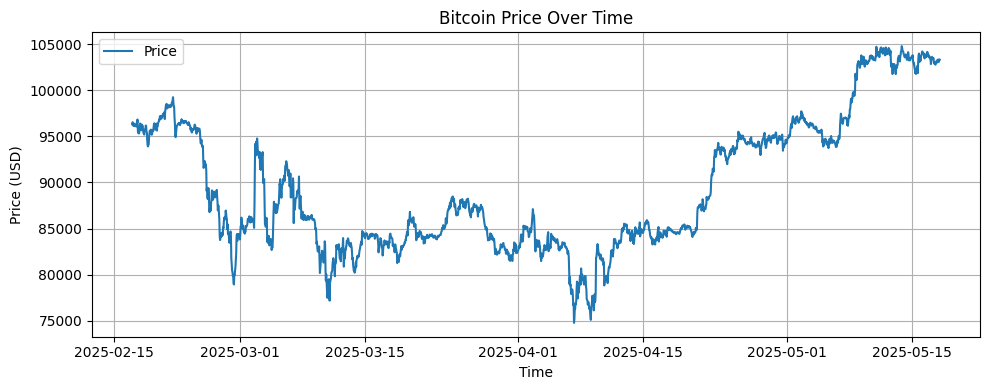

In [8]:
df_snapshots = graph.run("""
    MATCH (c:Coin)-[:HAS_SNAPSHOT]->(s:PriceSnapshot)
    WHERE c.id = 'bitcoin'
    RETURN s.timestamp AS time, s.price AS price, s.volume AS volume
    ORDER BY time
""").to_data_frame()

print(df_snapshots.columns)
print(df_snapshots.head())
# Convert to datetime
df_snapshots["time"] = pd.to_datetime(df_snapshots["time"], unit="s")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_snapshots["time"], df_snapshots["price"], label="Price")
plt.title("Bitcoin Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()